# Машинное обучение, DS-поток, осень 2024

## Задание ML.10


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Баллы за задание**  
Задача 1. &mdash; **200 баллов**  

Всего &mdash; **200 баллов**  

In [1]:
# Bot check

# HW_ID: ds_ml10
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
import time
import numpy as np
from collections import defaultdict

import seaborn as sns
sns.set(palette='Set2')
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
import torchvision
from torchvision import transforms
from captum.attr import Occlusion
#import captum_visualization as viz
from captum.attr import visualization as viz

### Задача 1. Исследование свойств сверток

#### 1. Данные

Обратимся к датасету CIFAR10. Скачаем тренировочную и тестовую части данных.

In [3]:
# Часть данных для обучения
train_dataset = torchvision.datasets.CIFAR10(
    root='./cifar', download=True, train=True, transform=transforms.ToTensor()
)

# Валидационная / тестовая часть данных
val_dataset = torchvision.datasets.CIFAR10(
    root='./cifar', download=True, train=False, transform=transforms.ToTensor()
)

# Классы объектов в датасете
classes = (
    'plane', 'car', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
)

Files already downloaded and verified
Files already downloaded and verified


Проверим размеры датасета.

In [4]:
len(train_dataset), len(val_dataset)

(50000, 10000)

Иллюстрируем 2 примера изображений.

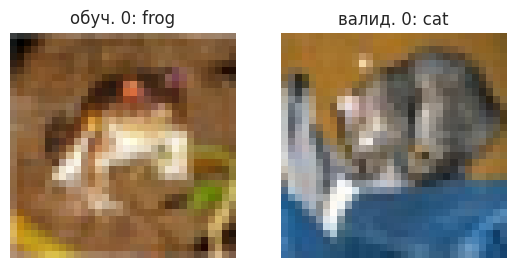

In [5]:
train_idx, val_idx = 0, 0

plt.subplot(1, 2, 1)
plt.imshow(train_dataset[train_idx][0].permute(1, 2, 0))
plt.title(f'обуч. {train_idx}: {classes[train_dataset[train_idx][1]]}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(val_dataset[val_idx][0].permute(1, 2, 0))
plt.title(f'валид. {val_idx}: {classes[val_dataset[val_idx][1]]}')
plt.axis('off')

plt.show()

#### 2. Различия между свертками

Постройте модель состоящую из 3 сверточных слоев с параметрами `kernel_size=3` и `stride=1` по правилу
$$INPUT \to [CONV \to RELU]^3 \to POOL \to FC \to RELU \to FC,$$

Также можно пользоваться `Dropout` и `BatchNorm`.
Пример аналогичного построения см. в семинаре.

Определение сети

In [6]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        
        # Первый слой
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()
        
        # Второй
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.3)
        self.relu2 = nn.ReLU()
        
        # Третий
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.3)
        self.relu3 = nn.ReLU()

        # Pool
        self.pool = nn.MaxPool2d(4)
        
        # FC
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.dropout4 = nn.Dropout(0.5)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.relu1(self.dropout1(self.bn1(self.conv1(x))))

        x = self.relu2(self.dropout2(self.bn2(self.conv2(x))))
        
        x = self.relu3(self.dropout3(self.bn3(self.conv3(x))))
        
        x = self.pool(x)

        x = self.flatten(x)
        x = self.relu4(self.dropout4(self.fc1(x)))
        x = self.fc2(x)
        return x

Функции для обучения и построения графиков обучения

In [7]:
def plot_histories(histories, names):
    '''
    Функция для вывода лосса и метрики во время обучения.
    :param history: (dict) accuracy и loss на обучении и валидации
    :param names: (dict) название модели
    '''
    sns.set_style('darkgrid')
    colors = ['darkblue', 'lightcoral', 'limegreen', 'sandybrown']
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = np.min([len(h['loss']['train']) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title('Лосс')
        axs[0].plot(history['loss']['train'][:epochs], label=f'{name}', lw=2, c=colors[i])
        axs[0].plot(history['loss']['val'][:epochs], lw=1.5, c=colors[i], ls='--')
        axs[0].set_xlabel('Эпохи')

        axs[1].set_title('Точность')
        axs[1].plot(history['acc']['train'][:epochs], label=f'{name}', lw=2, c=colors[i])
        axs[1].plot(history['acc']['val'][:epochs], lw=1.5, c=colors[i], ls='--')
        axs[1].set_xlabel('Эпохи')
        axs[1].legend()

    dummy_lines = [axs[0].plot([], [], c='black', lw=2)[0],
                   axs[0].plot([], [], c='black', lw=1.5, ls='--')[0]]
    for i in range(2):
        legend = axs[i].legend(loc=3-i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Логиты на выходе модели
            logits = model(X_batch)

            # Подсчитываем лосс
            loss = criterion(logits, y_batch.long().to(device))

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

            # Сохраняем лоссы и точность на трейне
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраняем в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полный проход по валидации
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Логиты, полученные моделью
            logits = model(X_batch)

            # Лосс на валидации
            loss = criterion(logits, y_batch.long().to(device))

            # Сохраняем лоссы и точность на валидации
            val_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраняем в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output(wait=True)

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

    return model, history

Выполните следующие действия.
1. Посчитайте общее количество параметров сети и количество параметров в сверточных слоях.
2. Обучите ее на тренировочной части данных и сохраните веса обученной модели.
3. Посчитайте среднее время одного прямого прохода (forward pass) и среднее время обратного прохода (backward pass) по сети во время обучения.
4. Сохраните историю изменения ошибки (loss) и точности (accuracy) во время обучения.


Проверка устройства

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Используемое устройство: {device}')

Используемое устройство: cuda:0


Число параметров

In [9]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    conv_params = sum(p.numel() for name, p in model.named_parameters() if 'conv' in name and p.requires_grad)
    print(f"Total Parameters: {total_params}")
    print(f"Convolutional Layer Parameters: {conv_params}")

model = SimpleConvNet()
model.to(device)
count_parameters(model)

Total Parameters: 2193674
Convolutional Layer Parameters: 93248


Обучение

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=64, shuffle=False)

model, history = train(model, criterion, optimizer,
                       train_loader, val_loader, num_epochs=40)

torch.save(model.state_dict(), 'fist_model.pth')

Epoch 40 of 40 took 19.503s
  training loss (in-iteration): 	0.954642
  validation loss (in-iteration): 	0.784191
  training accuracy: 			64.27 %
  validation accuracy: 			73.84 %


Подсчет времени

In [11]:
def compute_average_times(train_loader, model, criterion, device):
    total_forward_time = 0
    total_backward_time = 0
    num_batches = len(train_loader)

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        start_time = time.time()
        logits = model(X_batch)
        forward_time = time.time() - start_time
        total_forward_time += forward_time

        start_time = time.time()
        loss = criterion(logits, y_batch)
        loss.backward()
        backward_time = time.time() - start_time
        total_backward_time += backward_time

    avg_forward_time = total_forward_time / num_batches
    avg_backward_time = total_backward_time / num_batches

    print(f"Среднее время прямого прохода на батч: {avg_forward_time:.5f}с")
    print(f"Среднее время обратного прохода на батч: {avg_backward_time:.5f}с")

И сам подсчет

In [12]:
compute_average_times(train_loader, model, criterion, device)

Среднее время прямого прохода на батч: 0.00121с
Среднее время обратного прохода на батч: 0.00200с


График обучения

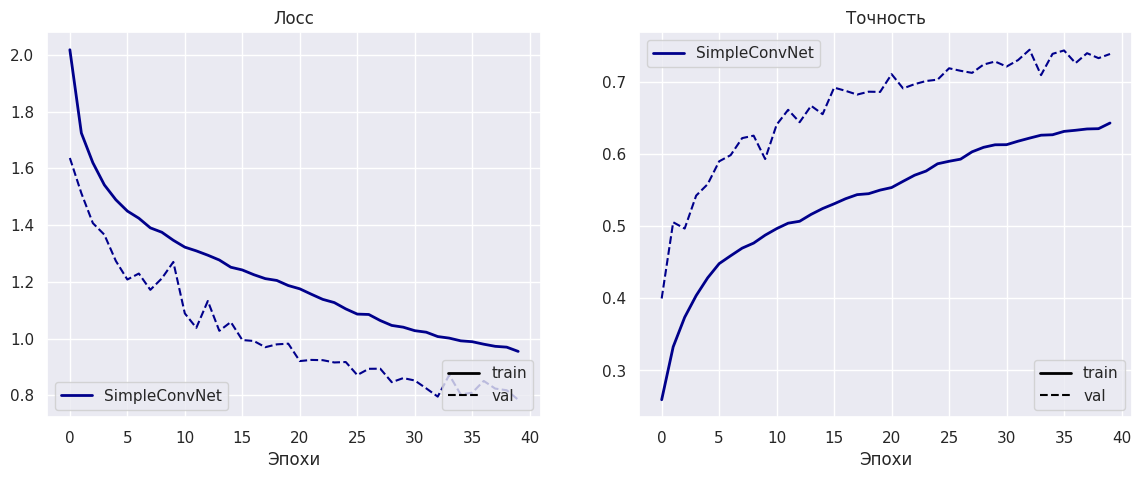

In [13]:
plot_histories([history], ['SimpleConvNet'])

Посчитайте область видимости (receptive filed) нейронов последней свертки. Какую область картинки видит нейрон последнего слоя свертки?

**Ответ:** 

Каждый сверточный слой с параметрами kernel_size=3, stride=1, и padding=1.

Receptive field растет итерационно на сверточных слоях:

$$RC_n = 2(RC_{n-1} - 1) + 3$$

откуда на выходе из третьего слоя $RC_3 = 7$ ($RC_0 = 1$)

Нейрон последнего словия видит область 7х7

Проведем эксперимент для сравнения работы различных сверток. Для этого постройте еще три модели, которые должны следовать перечисленным ниже требованиям.

Во-первых, необходимо сделать такие модели, у которых область видимости (receptive field) последнего сверточного слоя такая же как у модели построенной ранее. Тогда мы будем ожидать у моделей схожую обобщающую способность.

Во-вторых, установим ограничение на количество каналов в свертках. Оно нужно для корректной оценки параметров и скорости работы сети. Пусть $с_{k,in}$ и $c_{k, out}$ &mdash; количество каналов на входе и на выходе свертки на слое $k$ модели. Тогда сумма $\sum_{k} с_{k,in} c_{k, out}$ должна быть одинаковой для всех моделей, т.е. для исходной и трех новых моделей. Для того, чтобы добиться такого результата, можно дополнительно использовать свертки с `kernel_size=1`. При сравнении моделей в выводе поясните необходимость данного требования.

Наконец, т.к. мы хотим рассмотреть работу различных сверток, то перечислим особенности каждой модели по порядку.

1. Включает в себя свертку c `kernel_size=7, stride=1`.
2. Включает в себя свертку c `kernel_size=5, stride=1`.
3. Включает себя свертки c `kernel_size=3, stride=2`.

Определение моделей

In [14]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.3)
        
        self.conv3 = nn.Conv2d(32, 128, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.3)
        
        self.pool = nn.MaxPool2d(4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = nn.ReLU()(self.conv2(x))
        x = nn.ReLU()(self.conv3(x))
        x = self.flatten(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.3)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.3)
        
        self.pool = nn.MaxPool2d(4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = nn.ReLU()(self.conv2(x))
        x = nn.ReLU()(self.conv3(x))
        x = self.flatten(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

class Model4(nn.Module):
    def __init__(self):
        super(Model4, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.3)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.3)
        
        self.pool = nn.MaxPool2d(4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = nn.ReLU()(self.conv2(x))
        x = nn.ReLU()(self.conv3(x))
        x = self.flatten(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

Обучите новые модели с теми же параметрами обучения, что и раньше. Для каждой из них посчитайте все характеристики, которые были посчитаны для исходной модели. Сравните результаты и сделайте выводы.

Обучение

In [15]:
models = [Model2().to(device), Model3().to(device), Model4().to(device)]
model_names = ["Model2 (k=7, s=1)", "Model3 (k=5, s=1)", "Model4 (k=3, s=2)"]

batch_size = 64
num_epochs = 40
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

histories = []
for model, name in zip(models, model_names):
    print(f"Training {name}")
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    count_parameters(model)
    
    model, history = train(model, criterion, optimizer, train_loader,
                           val_loader, num_epochs=num_epochs)
    histories.append(history)
    
    torch.save(model.state_dict(), f'{name}_weights.pth')


Epoch 40 of 40 took 19.817s
  training loss (in-iteration): 	0.077999
  validation loss (in-iteration): 	2.578306
  training accuracy: 			97.35 %
  validation accuracy: 			69.44 %


Подсчет времени

In [16]:
for model, name in zip(models, model_names):
    print(f"Модель {name}")
    compute_average_times(train_loader, model, criterion, device)

Модель Model2 (k=7, s=1)
Среднее время прямого прохода на батч: 0.00087с
Среднее время обратного прохода на батч: 0.00146с
Модель Model3 (k=5, s=1)
Среднее время прямого прохода на батч: 0.00084с
Среднее время обратного прохода на батч: 0.00148с
Модель Model4 (k=3, s=2)
Среднее время прямого прохода на батч: 0.00086с
Среднее время обратного прохода на батч: 0.00148с


Графики

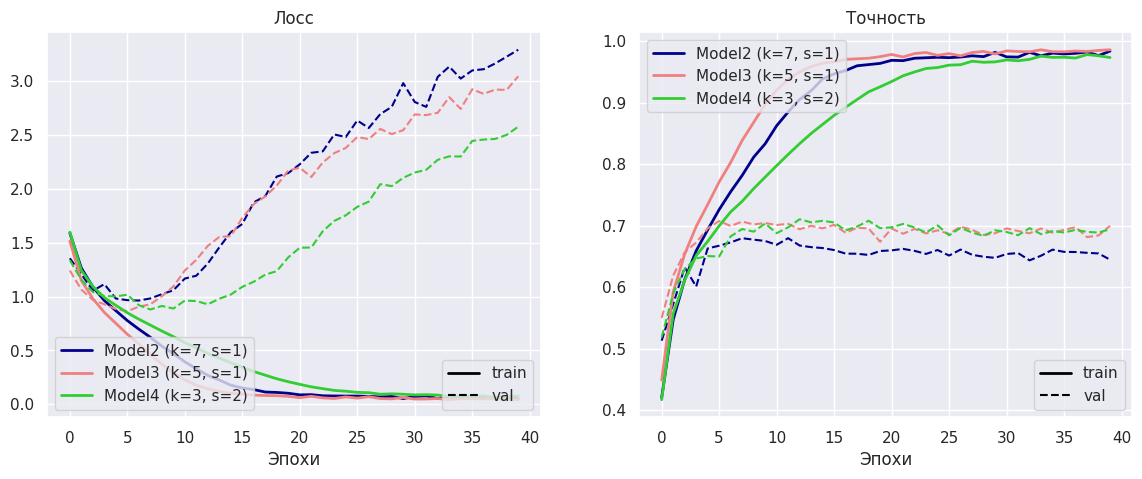

In [17]:
plot_histories(histories, model_names)

**Выводы:**

Манипулируя stride и kernel можно ускорить обучение/улучшить качество модели.

Больше kernel - больше видит нейрон, тем больше обобщающая способность у модели. Stride позволяет уменьшить размерность выхода, тем самым модель ускоряется и становится проще.

#### 3. Интерпретируемость
В этой части задания вы попробуете еще один способ интерпретации работы сверточных слоев. На лекции и семинаре для того, чтобы показать что нейроны реагируют на отдельные части изображения, использовались выходы сети целиком. Сейчас же вы сможете проверить, есть ли интерпретируемость на уровне сверточных слоев.

1. Выделите 5 изображений лягушек и 5 изображений самолетов из датасета.
2. Выберете одну из четырех обученных моделей.
3. Для каждого изображения посчитайте выходы последнего сверточного слоя модели и найдите максимумы по каналам. Должен получиться квадратный двумерный тензор для каждого изображения. Он показывает на какие области больше всего реагирует сеть для предсказания соотвествующего класса.  
4. Отобразите результат для каждого изображения.
5. Сравните активации для изображений одного класса и различных классов. Сделайте выводы.

Найдем в лоб выход последнего сверточного слоя, не модифицируя исходный код модели

In [20]:
def get_last_conv_activations(model, image):
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)
        for layer in model.children():
            x = layer(x)
            if isinstance(layer, nn.Conv2d):
                last_conv_output = x
    return last_conv_output

Итого

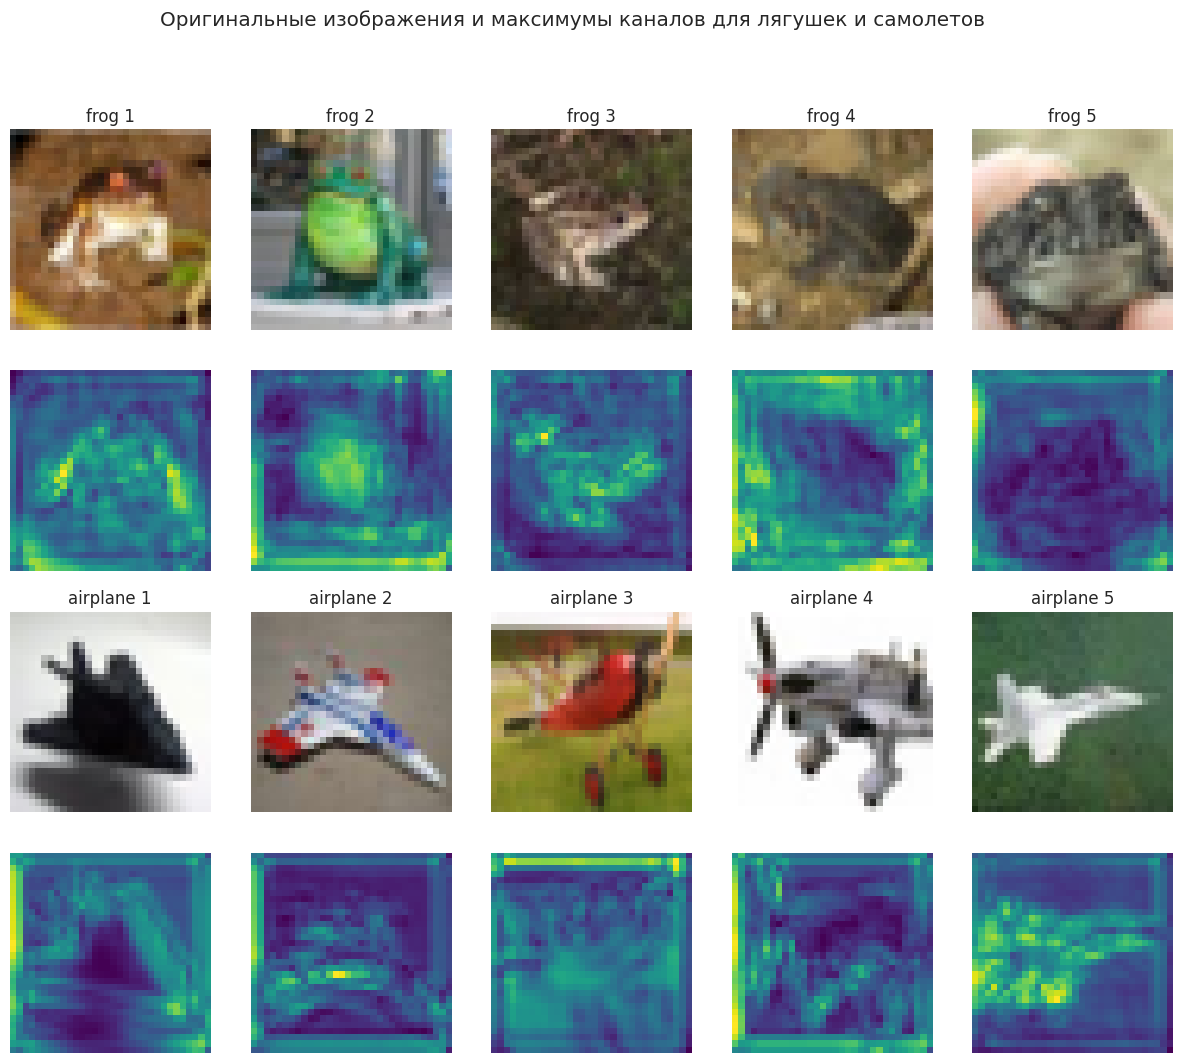

In [21]:
model = models[0]
model.eval()

transform = transforms.Compose([
    transforms.ToTensor()
])

frog_images = [img for img, label in train_dataset if label == 6][:5]
airplane_images = [img for img, label in train_dataset if label == 0][:5]

images = frog_images + airplane_images
image_labels = ['frog'] * 5 + ['airplane'] * 5

fig, axs = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle("Оригинальные изображения и максимумы каналов для лягушек и самолетов")

for i, (image, label) in enumerate(zip(images, image_labels)):
    activations = get_last_conv_activations(model, image)
    activation_map = activations.squeeze().max(dim=0)[0].cpu().numpy()

    if label == 'frog':
        ax = axs[i // 5, i % 5] 
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(f"{label} {i % 5 + 1}")
        ax.axis('off')

        ax = axs[(i // 5) + 1, i % 5]
        ax.imshow(activation_map, cmap='viridis')
        ax.axis('off')

    else:
        ax = axs[(i - 5) // 5 + 2, (i - 5) % 5]
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(f"{label} {i % 5 + 1}")
        ax.axis('off')

        ax = axs[(i - 5) // 5 + 3, (i - 5) % 5]
        ax.imshow(activation_map, cmap='viridis')
        ax.axis('off')

plt.show()

**Вывод:** 

Модель использует разные части изображения в зависимости от класса. Для лягушек активации это области тела животного, а для самолетов активации чаще всего фиксировались на контуре и крыльях. Что ожидаемо, потому что это главные части изображения. Так, у нас есть способ визуализировать работу модели и понять как она работает

На семинаре мы реализовали окклюзию самостоятельно, но она реализована и в библиотеке Captum. Выберите другие 2 класса и примените окклюзию к 5 случайным представителям из каждого класса. Пример визуализации в Captum смотрите в семинаре. Что модель считает важным для определения выбранных классов?

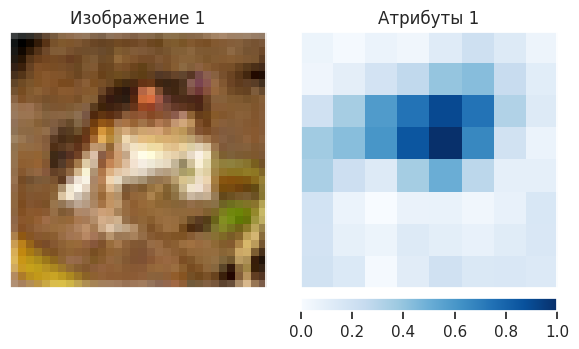

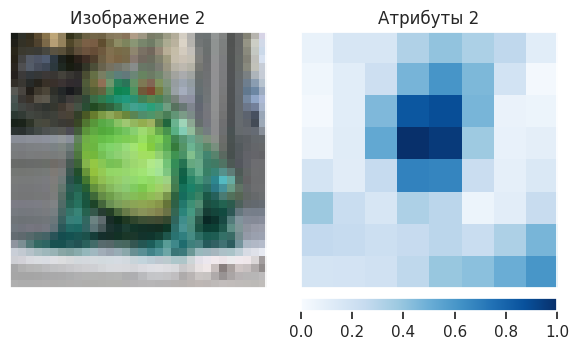

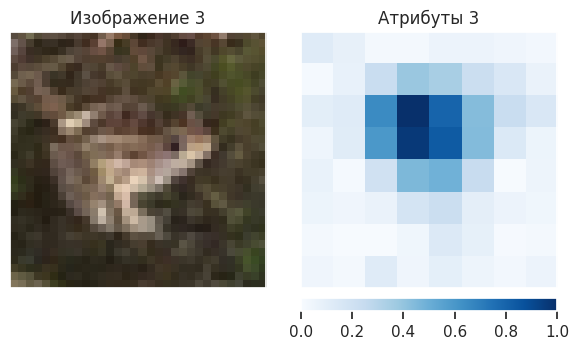

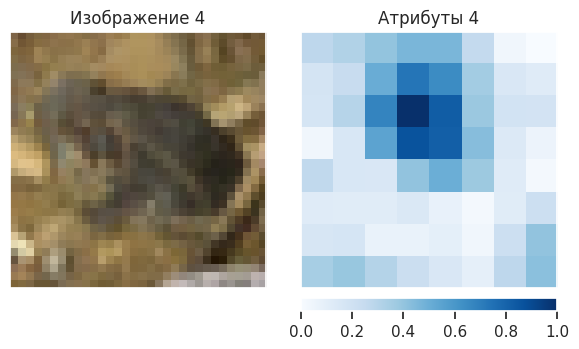

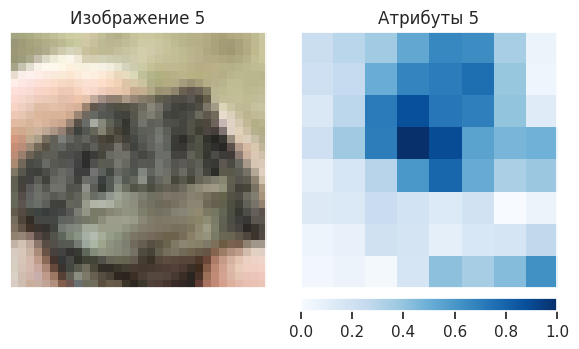

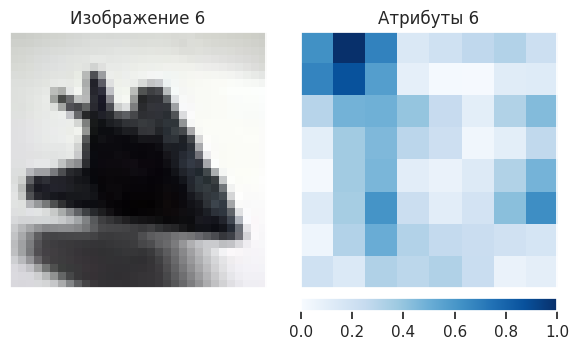

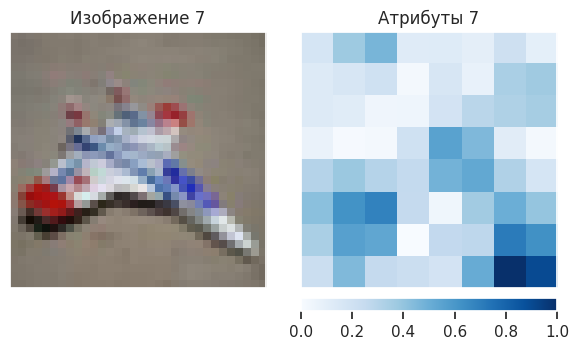

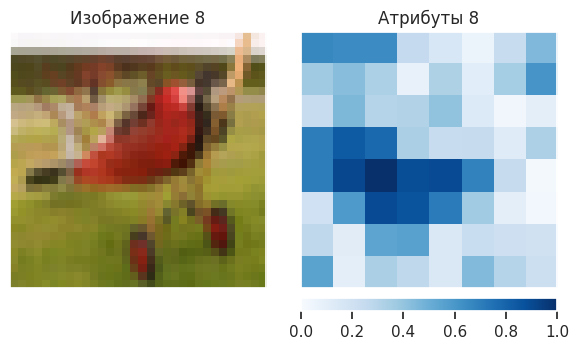

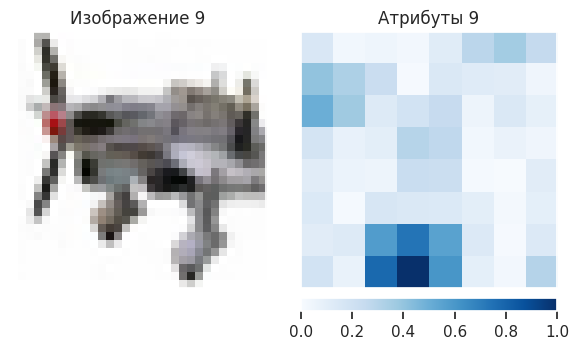

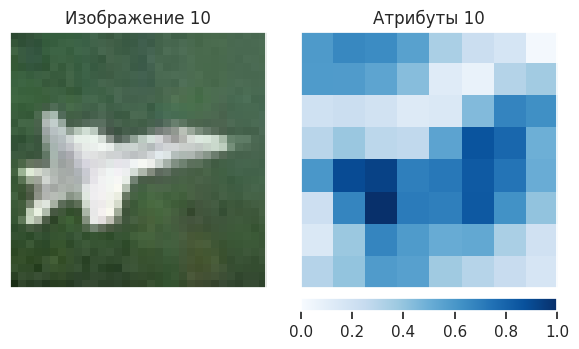

In [22]:
occlusion = Occlusion(model)
fig.suptitle("Окклюзия изображнией для лягушек и самолетов")

for i, (image, label) in enumerate(zip(images, image_labels)):
    input_tensor = image.unsqueeze(0).to(device)

    attributions = occlusion.attribute(
            input_tensor,
            strides=(3, 4, 4),  
            sliding_window_shapes=(3, 8, 8),  
            target=model(input_tensor).argmax(dim=1).item()
    )

    attributions_np = attributions.squeeze().cpu().detach().numpy()
    attributions_np = np.transpose(attributions_np, (1, 2, 0))

    viz.visualize_image_attr_multiple(
        attributions_np,
        np.transpose(input_tensor.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        methods=["original_image", "heat_map"],
        signs=["all", "absolute_value"],
        titles=[f"Изображение {i+1}", f"Атрибуты {i+1}"],
        fig_size=(6, 5),
        show_colorbar=True,
        outlier_perc=2
    )

Итого: самые важные части изображения - границы объектов, самые важные их части - что и следовало ожидать при обучении нейросети.

#### 4. Выводы
На основе выполненного здания сделайте выводы об особенностях работы сверток.

1) Свертки с большим ядром обеспечивают более широкий контекст, но они также требуют больше вычислительных ресурсов. Свертки с меньшим ядром более эффективны и захватывают локальные признаки. Свертки с большими шагами уменьшают размер выходных карт признаков, но могут терять информацию о мелких деталях. В итоге, подбор гиперпараметров параметров свертки зависит от конкретной задачи: если нам нужны глобальные признаки объектов, то стоит использовать большие ядра, тогда как для маленьких объектов  — маленькие ядра и шаги свертки.
2) Окклюзия показывает, какие части изображения модель считает наиболее важными для принятия решения о классе. Для разных классов модель реагирует на разные ключевые области. Это подтверждает гипотезу о том, что сверточные нейронные сети учат модели фокусироваться на характерных признаках каждого класса. К такому же выводу можно прийти и рассматривая выходы отдельных сверточных слоев.